In [1]:
!pip install keras_tuner # Only necessary on Colab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 35.2 MB/s 
     |████████████████████████████████| 1.6 MB 41.2 MB/s 


# Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Layer, Dense, LSTM, Input, RepeatVector, TextVectorization
import keras_tuner as kt
from keras.losses import mse #binary_crossentropy, mean_squared_error
from keras.models import Model
from keras import backend as K
import pandas as pd
import seaborn as sns
import scipy
from random import shuffle
import matplotlib.pyplot as plt


2023-01-03 22:45:54.564376: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-03 22:45:54.564427: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-03 22:45:56.715881: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-03 22:45:56.715987: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-03 22:45:56.715999: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT War

## Data Processing: list --> tensor

In [34]:
grampaSeqences = []
with open("data/grampaReduced.csv", "r") as grampaFile: # MAKE sure that .csv is discoverable @ path.
    lines=grampaFile.readlines()

allSequences = []
for idx, string in enumerate(lines[1:]): # line 0 is header
    allSequences.append([string.split(",")[0].strip("\""),string.split(",")[1].strip("\n\"")]) # Clean strings

allSequencesdf = pd.DataFrame(allSequences)
allSequencesdf.rename(columns={0:"Sequence", 1:"Species"}, inplace=True)
mask = allSequencesdf["Sequence"].str.contains("[klgarivfspctwnhqyedm]", case=False, regex=True) # Only standard aa's.

# Inversion of the mask allows us to look at the excluded sequences. 
# mask = ~mask

# Use the mask to filter the dataframe
allSequencesdf = allSequencesdf[mask]
data = allSequences

In [33]:
len(data)

51345

In [27]:
def remove_non_standard(words): #filter out undesirable sequences (non-standard aa for now)
    return [word for word in words if "U" not in word and "X" not in word and "" not in word]
len(remove_non_standard(justSequences)) - len(justSequences)

-31795

In [69]:
pd.set_option('display.max_rows', 50)
np.set_printoptions(edgeitems=50, linewidth=100)

In [128]:
new_vocab = ['K','L','G','A','R','I','V','F','S','P','C','T','W','N','H','Q','Y','E','D','M']
len(new_vocab)

20

In [127]:
%%time
max_aa_length = 50
aa_vocab_size = 22# 20 standard aa's, 1 start/null token, 1 oov "[UNK]" token 

aa_sequences=[d[0] for d in data]

# Build 
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
vectorize_aa = tf.keras.layers.TextVectorization(split="character", output_mode="int",
#                                                  pad_to_max_tokens=True, 
                                                 output_sequence_length=max_aa_length, 
                                                 standardize=None, vocabulary=new_vocab) # max_tokens=aa_vocab_size, 
# vectorize_aa.adapt(aa_sequences)
model.add(vectorize_aa)

# Apply
vectorized_aa=model.predict(aa_sequences)
vectorized_aa = keras.utils.to_categorical(vectorized_aa, num_classes=aa_vocab_size)
vectorized_aa


ValueError: Attempted to set a vocabulary larger than the maximum vocab size. Passed vocab size is 22, max vocab size is 20.

In [113]:
vectorized_aa[0].shape # View an example of a vectorized aa sequence.

(50, 22)

In [114]:
"".join(vectorize_aa.get_vocabulary())

'[UNK]KLGARIVFSPCTWNHQYEDM'

In [116]:
species_vocab_size = 20 # PLACEHOLDER VAL
species=[d[1] for d in data]
# vectorize_aa.adapt(species)

# Build
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
vectorize_species = tf.keras.layers.TextVectorization(split=None, output_mode="int", max_tokens=species_vocab_size)

# Apply
vectorize_species.adapt(species)
species_vocab_size = vectorize_species.vocabulary_size()
model.add(vectorize_species)

vectorized_species = model.predict(species)
vectorized_species = keras.utils.to_categorical(vectorized_species, num_classes=species_vocab_size)
print(vectorized_species)


1605/1605 [==============================] - 3s 2ms/step
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

# Model Building Functions

## Hyperparameter tuning model

In [ ]:

def build_model(hp):
    # Define input layers for the two strings
    input_aa = tf.keras.Input(shape=(50,aa_vocab_size), name='aa')
    input_species = tf.keras.Input(shape=(species_vocab_size,), name='species')

    vectorized_aa = input_aa
    vectorized_species = input_species
    
    # hyperparams
    aa_LSTM_units = hp.Int('aa_LSTM_units', min_value=5, max_value=200, step=5)
    species_Dense_units = hp.Int('species_Dense_units', min_value=1, max_value=30, step=4)
    latent_dim = hp.Int('latent_dim', min_value=1, max_value=12, step=1) # Must be < 20 for undercompleteness. There are ~10 descriptors
    # latent_dim=2
    output_activation = hp.Choice('output_activation', values=['softmax','linear'])

    # aa encoder
    encoder_aa = tf.keras.layers.LSTM(units=aa_LSTM_units, return_sequences=True)(vectorized_aa)

    # species encoder
    encoder_species = tf.keras.layers.Dense(units=species_Dense_units)(vectorized_species)
    encoder_species = tf.keras.layers.Dense(units=aa_LSTM_units)(encoder_species) # for concatenation
    encoder_species = keras.layers.Reshape((1,encoder_species.shape[1]))(encoder_species)
    encoder = tf.keras.layers.Concatenate(axis=1)([encoder_aa, encoder_species]) # GEt SHAPES RIGHT so this works.
    # encoder= [encoder_aa, encoder_species]
    

    # Latent space parameters
    
    latent_mean = tf.keras.layers.Dense(units=latent_dim)(encoder) # fully encoded
    latent_log_var = tf.keras.layers.Dense(units=latent_dim)(encoder) # fully encoded


    # Sample from the latent space
    def sampling(args):
        mean, log_var = args
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(mean))
        return mean + tf.exp(0.5 * log_var) * epsilon

    latent = tf.keras.layers.Lambda(sampling)([latent_mean, latent_log_var])

    # Decoder
    decoder_aa = tf.keras.layers.LSTM(units=aa_LSTM_units, return_sequences=True)(latent)
    decoder_species = tf.keras.layers.Dense(units=species_Dense_units)(latent)

    # Output layers
    output_aa = tf.keras.layers.Dense(aa_vocab_size, activation=output_activation, name='aa_output')(decoder_aa[:,:max_aa_length]) # What activation?

    output_species = tf.keras.layers.Dense(species_vocab_size, activation=output_activation, name='species_output')(decoder_species[:,max_aa_length:])

    # Wasserstein loss function
    # def wasserstein_loss(y_true, y_pred):
    #     product = tf.keras.layers.Multiply()([y_true, y_pred])
    #     return tf.keras.layers.Average()([product])
    # Compute the KL divergence loss
#     def kl_divergence_loss(y_true, y_pred):
#         kl_loss = 1 + latent_log_var - tf.square(latent_mean) - tf.exp(latent_log_var)
#         kl_loss = tf.reduce_mean(-0.5 * tf.reduce_sum(kl_loss, axis=-1))
#         return kl_loss

    # Compile the model
    mse = tf.keras.losses.MeanSquaredError()
    model = tf.keras.Model(inputs=[input_aa, input_species], outputs=[output_aa, output_species])
    model.compile(optimizer='adam', loss=[mse, mse], 
                  loss_weights=[1, .05], metrics=[tf.keras.metrics.KLDivergence()])
    return model


## Selected model architecture from HP tuning process

In [119]:
## BUILD MODEL
#-------------------------------------------------------------

def build_model_tuned(aa_LSTM_units, species_Dense_units, latent_dim, output_activation):
    # Define input layers for the two strings
    input_aa = tf.keras.Input(shape=(50,aa_vocab_size), name='aa')
    input_species = tf.keras.Input(shape=(species_vocab_size,), name='species')

    vectorized_aa = input_aa
    vectorized_species = input_species
    
    # aa encoder
    encoder_aa = tf.keras.layers.LSTM(units=aa_LSTM_units, return_sequences=True)(vectorized_aa)
#     encoder_aa = tf.keras.layers.Transformer(num_heads=8,
#                                          hidden_size=64,
#                                          num_encoder_layers=2)
    # species encoder
    encoder_species = tf.keras.layers.Dense(units=species_Dense_units)(vectorized_species)
    encoder_species = tf.keras.layers.Dense(units=aa_LSTM_units)(encoder_species) 
    encoder_species = keras.layers.Reshape((1,encoder_species.shape[1]))(encoder_species)
    encoder = tf.keras.layers.Concatenate(axis=1)([encoder_aa, encoder_species]) 
    # encoder= [encoder_aa, encoder_species]
    

    # Latent space parameters
    
    latent_mean = tf.keras.layers.Dense(units=latent_dim)(encoder) # fully encoded
    latent_log_var = tf.keras.layers.Dense(units=latent_dim)(encoder) # fully encoded


    # Sample from the latent space
    def sampling(args):
        mean, log_var = args
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(mean))
        return mean + tf.exp(0.5 * log_var) * epsilon

    latent = tf.keras.layers.Lambda(sampling)([latent_mean, latent_log_var])

    # Decoder
    decoder_aa = tf.keras.layers.LSTM(units=aa_LSTM_units, return_sequences=True)(latent)
#     decoder_aa = tf.keras.layers.Transformer(num_heads=8,
#                                          hidden_size=64,
#                                          num_decoder_layers=2)(latent)
    decoder_species = tf.keras.layers.Dense(units=species_Dense_units)(latent)

    # Output layers
    output_aa = tf.keras.layers.Dense(aa_vocab_size, activation=output_activation, name='aa_output')(decoder_aa[:,:max_aa_length]) # What activation?

    output_species = tf.keras.layers.Dense(species_vocab_size, activation=output_activation, name='species_output')(decoder_species[:,max_aa_length:])

    # Compile the model
    mse = tf.keras.losses.MeanSquaredError()
    model = tf.keras.Model(inputs=[input_aa, input_species], outputs=[output_aa, output_species])
    model.compile(optimizer='adam', loss=[mse, mse], 
                  loss_weights=[1, .05], metrics=[tf.keras.metrics.KLDivergence()])
    return model


## Model Training

### HP model

In [118]:
##  Train Model, save results

training_data = [vectorized_aa, vectorized_species] 
tuner = kt.Hyperband(
    build_model,
    objective=kt.Objective("val_aa_output_loss", direction="min"), # CHECK THIS
    max_epochs=300,
    hyperband_iterations=4,
    overwrite=True,
    seed=0,
    executions_per_trial=1)

tuner.search(training_data, training_data, epochs=1, validation_split=.1,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_aa_output_loss",
              mode="min", verbose=1, patience=5)])

# best_model = tuner.get_best_models()[0]
# tuner.get_best_hyperparameters(num_trials=1)[0]

# best_model.save("12-24VAE-mse-expandedhp", overwrite = True, 
#                  include_optimizer = True, save_format =None, 
#                  signatures = None , options = None, save_traces = True)

# def wasserstein_loss(y_true, y_pred):
#     product = tf.keras.layers.Multiply()([y_true, y_pred])
#     return tf.keras.layers.Average()([product])
# custom_objects = {"wasserstein_loss": wasserstein_loss}

# reconstructed_model = keras.models.load_model("./models/12-23WAE", custom_objects=custom_objects)

NameError: name 'build_model' is not defined

### Tuned Model

In [ ]:
# Retrain best model on data
from google.colab import files

num_top = 20
best_hp = tuner.get_best_hyperparameters(num_top) # get hyperparams of top <num_top> models
best_model_hp = tuner.hypermodel.build(best_hp[0]) # build the best one
best_model_hp.save("VAEmse") # save it


!zip -r /content/VAEmse.zip /content/VAEmse # zip it 
files.download("/content/VAEmse.zip")# download it

In [ ]:
with open("best_hyperparams.txt", "w") as best_hyperparams:
  for i in range(num_top):
    best_hyperparams.write(f"{str(best_hp[i].values)}\n")

files.download("best_hyperparams.txt")

In [ ]:
best_model_hp.summary()

 #### Train from Scratch (Not Recommended) then save

In [131]:
model_tuned = build_model_tuned(aa_LSTM_units=50, species_Dense_units=20, 
                  latent_dim=2, output_activation="softmax") # aa_LSTM_units doesn't apply for Transformer


In [27]:
model_tuned.layers[14]

In [ ]:
%%time
training_data = [vectorized_aa, vectorized_species] 

historyVAE = model_tuned.fit(training_data, training_data, epochs=1, validation_split=.1,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_aa_output_loss", min_delta=1e-10,
              mode="min", verbose=1, patience=5)])

In [ ]:
# !zip -r /content/full_hp_history.zip /content/untitled_project # zip it 
# files.download("/content/full_hp_history.zip")

In [ ]:
with open('/content/VAE_history', 'wb') as file_pi: # colab specific
    pickle.dump(historyVAE.history, file_pi)
files.download("/content/VAE_history") # colab specific

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model_tuned.save("VAE", overwrite = True, 
                 include_optimizer = True, save_format =None, 
                 signatures = None , options = None, save_traces = True)
!zip -r /content/VAE.zip /content/VAE # Colab specific
files.download("/content/VAE.zip") # Colab specific

#### Compare validation loss of two hp models

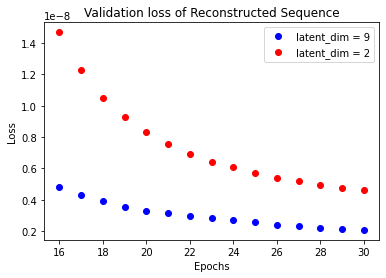

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [ ]:

val_aa_output_loss_50_20_9 = history_50_20_9.history["val_aa_output_loss"]
val_aa_output_loss_50_20_2 = history_50_20_2.history["val_aa_output_loss"]
epochs = range(1, len(val_aa_output_loss_50_20_9) + 1)

start_idx=15
# Plot the val_loss values against the epochs
plt.plot(epochs[start_idx:], val_aa_output_loss_50_20_9[start_idx:], 'bo', label='latent_dim = 9')
plt.plot(epochs[start_idx:], val_aa_output_loss_50_20_2[start_idx:], 'ro', label='latent_dim = 2')
plt.title('Validation loss of Reconstructed Sequence')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig("val_loss_comparison")
files.download("val_loss_comparison.png") # Colab Specific

In [ ]:
# best_model_hp.layers[3].get_weights()
# FIT MODEL
# best_model_hp.fit(training_data, training_data)

In [ ]:
# str(best_hp[0].values)

"{'aa_LSTM_units': 90, 'species_Dense_units': 21, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 7, 'tuner/round': 0}"

#### Load Pre-built model (Recommended)

In [125]:
# model_tuned = keras.models.load_model("/content/VAE-50-20-2")
model_tuned = keras.models.load_model("./models/VAE_50_20_2")

In [11]:
# model_tuned.layers[3].output.shape[1]
# model_tuned.layers[5].output.shape
model_tuned.layers[3].output.shape[1]

50

In [12]:
model_tuned.layers[6].output.shape

TensorShape([None, 51, 50])

In [9]:
# Params for testing purposes
latent_dim = 2
batch_size= 2000
total_length = model_tuned.layers[3].output.shape[1] # So far is 51, change

## Reconstruction Analysis (Analysis 1)

In [126]:
# sample_output = best_model_hp([vectorized_aa[100:200], vectorized_species[100:200]])
sample_output = model_tuned([vectorized_aa[0:100], vectorized_species[0:100]])

ValueError: Input 0 of layer "model_13" is incompatible with the layer: expected shape=(None, 50, 21), found shape=(100, 50, 22)

In [ ]:
sequence_idx = 0
num_samples = 100
reconstructed_sequences = []
# max_indices = tf.argmax(training_data[0][sequence_idx], axis=-1).numpy().astype(np.int32)
for i in range(num_samples):
  max_indices = tf.argmax(sample_output[0][i], axis=-1).numpy().astype(np.int32)
  max_indices
  aa_strings = vectorize_aa.get_vocabulary()
  reconstructed_sequences.append("".join(np.ndarray.tolist(np.array(aa_strings)[max_indices])).upper())



In [1]:

list(zip(reconstructed_sequences, aa_sequences)) # CHECK vectorize_aa mapping if this misbehaves. It's a known bug.

NameError: name 'reconstructed_sequences' is not defined

PERFECT reconstruction on all sequences.

In [ ]:
allSequences[0:100]

## Random Sampling - De Novo Sequence Analysis (Analysis 2)

In [63]:
decoder_lstm = model_tuned.layers[10]

In [64]:
aa_output_Dense = model_tuned.layers[-2] 

In [65]:
latent_sampling_layer = model_tuned.get_layer("lambda_13")
latent_sampling_layer


In [211]:
z_mean = np.full(shape=(batch_size,total_length,latent_dim), fill_value=0.0) # Basically the two features
# z_mu
z_log_var = np.full(shape=(batch_size,total_length,latent_dim), fill_value=40.0) # Basically the two features

# z_mu_2 = np.array([0.0, 0.0])

# z_sigma = np.array([1.0, 1.0])
# temperature = 1.0
latent_vector = latent_sampling_layer([z_mean,z_log_var]) # To characterize a given 2D gaussian
latent_vector.shape


TensorShape([2000, 50, 2])

In [202]:
# this method is selecting a random mean & var. Not all that insightful for the model analysis.
# latent_vector = latent_sampling_layer([np.random.normal(loc=z_mu_1, scale=temperature, 
#                                                         size=(batch_size,total_length,latent_dim)), 
#                                        np.random.normal(loc=z_mu_2, scale=temperature, 
#                                                         size=(batch_size,total_length,latent_dim))]) # last feature is species
# latent_vector = latent_sampling_layer([np.zeros(shape=(batch_size,51,latent_dim)), 
                                      #  np.zeros(shape=(batch_size,51,latent_dim))]) 
                                      #  np.random.normal(size=(1,51,2))]) # last feature is species

In [192]:
# latent_vector = tf.reshape(latent_vector, (1,1,2))

In [193]:
# latent_vector = tf.reshape(latent_vector, (1,1,3))
# tf.shape(latent_vector)
# latent_vector

In [194]:
# decoder_lstm.input
latent_sampling_layer.output

<KerasTensor: shape=(None, 51, 2) dtype=float32 (created by layer 'lambda_13')>

In [195]:
decoder_lstm.input

<KerasTensor: shape=(None, 51, 2) dtype=float32 (created by layer 'lambda_13')>

In [212]:
# Sample from the latent space

# latent_vector = np.random.normal(size=(1, 2, latent_dim))

# Use the decoder model to generate a sequence from the latent vector
decoded_sequence = decoder_lstm(latent_vector)
decoded_sequence
# output_aa = tf.keras.layers.Dense(aa_vocab_size, 
# activation=output_activation, name='aa_output')(decoder_aa[:,:max_aa_length]) # What activation?
generated_sequence_tensor = aa_output_Dense(decoded_sequence[:,:max_aa_length])

<tf.Tensor: shape=(2000, 50, 21), dtype=float32, numpy=
array([[[1.62698086e-08, 3.09258563e-10, 8.39254888e-10, ...,
         1.62438937e-07, 1.50861609e-07, 2.99582648e-09],
        [1.04233573e-08, 5.77972982e-11, 1.13801440e-10, ...,
         5.51011254e-08, 6.92877151e-08, 1.62293678e-09],
        [1.92665539e-05, 4.53349003e-08, 1.72583349e-02, ...,
         1.32436969e-06, 3.15316697e-08, 5.10519953e-04],
        ...,
        [1.12416977e-02, 3.89522858e-09, 9.88361299e-01, ...,
         1.38149989e-08, 5.03197413e-08, 1.45414258e-08],
        [4.12773603e-04, 3.35052475e-09, 9.99557436e-01, ...,
         1.97992089e-09, 3.32556049e-09, 4.83001283e-09],
        [1.87034748e-04, 3.19816995e-09, 9.99783516e-01, ...,
         2.24655694e-09, 1.33672717e-09, 5.57301227e-09]],

       [[1.43768402e-05, 1.86784970e-08, 2.57727265e-07, ...,
         7.54333058e-08, 9.01411340e-07, 2.48410204e-09],
        [9.96558461e-03, 1.88238687e-07, 4.11622925e-04, ...,
         9.72065322e-07, 2.

In [214]:
de_novo_sequences = []
for i in range(batch_size):
  max_indices = tf.argmax(generated_sequence_tensor[i], axis=-1).numpy().astype(np.int32)
  max_indices
  aa_strings = vectorize_aa.get_vocabulary()
  de_novo_sequences.append("".join(np.ndarray.tolist(np.array(aa_strings)[max_indices])).upper())

de_novo_sequences

['GGLVGKGLLKKVLGLKRGVGRRFIRAAKGGKKKVKGVVKKKIKIRVCKKK',
 'IRIRKKLRGVGKVVKKLGIFGGGRLILKKIKGLIKRGGIGRRCKRKIVR',
 'RKGRRKKGVLGKGGLRGGRKKLLKKGLFGILVRRVRIGKRKKRRKLKRIK',
 'FRIRRGILRKKVIVLALKRRRKRKGAKGKALKKKGRGRGIKKGGKGKLRK',
 'LARLVGKIKGLGLRKRKGKGRKVLKKIGGLKRLIIIIRRARFIKAKCFLL',
 'VLGARKGRVLVGFAKGGLGKLKIVRLVKIIRKRRRVVGVGLGIGVRKKR',
 'FLGFIGRCLIAIIGRKLGRKLVLVKVIKKRLIKLVIIKKGRALFGLAIGI',
 'GKRGGLVLGLGGGFAAIIGVKIARVIKIRVVGLKGVGVGLRRLAGGIR',
 'KGGGARGLARVKLKAKLIRVGGIRGFGVKGKIKRVKVVGLGVKLIRIIG',
 'AVGKGLKKLVGFFKGGRRVRGKAGKLGGKIKRLGVGGRGLGGLGGGRAAG',
 'GRGKIKLKFVIGIARVGRIGVLAGFGVKKKIRGRGGLCKFGIKLGLLRRA',
 'KGGVKGKLKGFIFGIAGGIGIIAKAGGKKIIIKIFGIGIKVGGGGRKKRK',
 'GGAFGKILCLLGAAKVRIFGKGLGRGLIKVGRIIRGGKVGRKRGKLAIIG',
 'VLVRIKKICFKVLACLLGAGIGKRGGVGKLKVVGRGIRRGRGIILIKKLL',
 'KGKVVKVKVGKLRRGLRGRKLGCKKAVRGKRGFLLRGARGKRGIIVVVKR',
 'IGLRRKGGVKIKLLRGRIIKRKKGKFIRLRGGVKKGVGILRFGGIVGLKR',
 'IKAIVGIVKAGVVGGGKGKVRVGKKVVRGRFKVAGVGRILGRVLLRRAV',
 'GFVKFAKGKIIKKFLKIVRIGLIRLRVKRRKKGKKKRKFIRIGFVKAGKK',
 'GRGKLALGRKVKRR

In [187]:
sample_seqs = ['YGYQ[UNK]ED[UNK]DYEQE[UNK]EEYYWYYYEYQEYEEHEEEE[UNK][UNK]YEYYYYEEDYE[UNK]DY',
 'YYEQYEYQYD[UNK]YEQYHD[UNK]YEEEEDEDQ[UNK]YYENEDE[UNK]EEDDEEYQEEDQYY',
 'EQQEEDQDEEYEEEEDYEEQEEEDYEYEYYEEQN[UNK]EDEDNYYYDEEYE[UNK]E',
 'DYYEEE[UNK]QEYQYYDDEEEYEEEE[UNK]YEYDQDEDTEYEDYYQYEEEEYYQDY',
 'WE[UNK][UNK]Q[UNK]QEEYYNY[UNK]YEEDEDEYGTQ[UNK]EEDYEEEYYEDYDDYY[UNK]D[UNK]YEEED',
 'PRYEDQ[UNK]EYQ[UNK]Y[UNK]EEYDEEE[UNK]EEYEEDYEEYEEEDEE[UNK]EEHEEEY[UNK]EDEE',
 'D[UNK]EYEYQE[UNK]YEQ[UNK][UNK]DYEQEDYE[UNK]YEYEEEEDEY[UNK]Q[UNK]EQ[UNK]YEYQQYEYEY[UNK]',
 'EQQEHYD[UNK]YYEEEE[UNK]YDEED[UNK]YYYYDEDEYD[UNK][UNK][UNK]E[UNK]YEDDY[UNK]YEEEEEYE',
 'DE[UNK]QYQEEEEDY[UNK]Y[UNK]HEEDYEDYEEQED[UNK]D[UNK]YYEQWD[UNK]EYYEEY[UNK]EDEE[UNK]',
 'PYQYEYEED[UNK]EEEEEYDYEYEYEEEYDEQQ[UNK]EQ[UNK]PPDEEEEYQEDENYYE',
 '[UNK]ENEYDQDEYQD[UNK]Y[UNK]D[UNK]YY[UNK]EYEWEEEY[UNK]YYYQDQ[UNK]EDEDE[UNK]EYEEY[UNK]YD',
 '[UNK]PEYYEEYEEHEEDEE[UNK]EDQEEQDEEEEYNYQEDQ[UNK]DPDDQYYQE[UNK]QW[UNK]E',
 'HPDQYEEYYDQEYYYYEDYQ[UNK]EYEEDEY[UNK]YYDEEYEYYYYDDEEEEYEEE',
 'WDQEQE[UNK]EEEEEYEQEYYEEEEEYEEY[UNK]YYEYDPQDY[UNK]EQYY[UNK]EDQNWYE',
 '[UNK][UNK]Y[UNK]Y[UNK]E[UNK]YEEYEEDEEQEEYYYEYYEEYQWQEYE[UNK]YYEEEYEE[UNK]EEY[UNK]Y',
 'EYYEYYYEDEYQYYDYYY[UNK]DDEE[UNK]PY[UNK]E[UNK]DYWDEYDYE[UNK]HYEW[UNK]EYEDYE',
 'TQQEEEEEEEYEEYDQYYQYD[UNK]E[UNK]YEQY[UNK]YWEQEEDHEYY[UNK]YDYYYPD[UNK]Q',
 'WWEED[UNK]E[UNK]EYE[UNK][UNK]YDD[UNK]QEYYNYEENYD[UNK]YEEQ[UNK][UNK]QY[UNK]EEE[UNK]EEENYWNE',
 'DEYEEEYYDEENEYDEEPEDYEYYED[UNK]YQDYDYEYEEQDDEYEYEQYEEE',
 'QEYDENQEYEDEEQDYEYQEYYYEYE[UNK]QEEDD[UNK]EEEYEYYE[UNK]YG[UNK][UNK]EEEE',
 '[UNK]EDYEY[UNK]E[UNK]EEEQE[UNK]YY[UNK]D[UNK]EEEDDYD[UNK]Q[UNK]EE[UNK]YDEEQEEQYEDDY[UNK]EEY',
 '[UNK]EEDYEQYE[UNK]PYEYEEHEEYEYQ[UNK]EYE[UNK]EEYE[UNK]YYEEDYEYYEQDYEEQE',
 '[UNK]HNEEDE[UNK]WEEEYDEY[UNK]HEDEEDEWEEEYDE[UNK]EYEYEYEYE[UNK][UNK]EYYEYEY',
 'EEEDYEYDYQYYYEEYEYDEYEQEQ[UNK]YY[UNK]EYEDE[UNK]YEDEEEQDPEYE[UNK]EQ',
 'WPHYEDEWYYYDDYD[UNK]YQEEY[UNK]YQYEYEDEEEEHEE[UNK]QEYEEEEYDYEEE',
 'DQDEYYWEEEWYD[UNK]EYYPYDEEDHEEEEY[UNK]QEYEEYEYEYEQEDYQYEEE',
 'WEEEPEEY[UNK]EEYWNDQEYYEDEYEYEYDEYEDEYEYYYYYE[UNK]EEEQEEEQ',
 '[UNK]PEYPYDDDEEEDE[UNK]YDDYY[UNK][UNK]QDDDYY[UNK]QYQYQEEQ[UNK]YE[UNK]YYQDEYWYD',
 'DEEYYYEDEEPYDYYYEYHYQYENDQDE[UNK]E[UNK]E[UNK][UNK]YEE[UNK]Q[UNK]EDYEEEEEYD',
 '[UNK][UNK]DNY[UNK]EEYYEYWYQEDEP[UNK]YDEYYD[UNK]EYYY[UNK]EDNEDQ[UNK]EYEYQED[UNK]QYE',
 'YDEYEYYY[UNK]EEQDYY[UNK][UNK]NEYEEYYQEEEEYYE[UNK]EE[UNK]EEY[UNK]EYEQYEYYEE',
 'NYEQH[UNK]YEYYEEPQEDQEWD[UNK]QEE[UNK]EYDEEDEYYWEHEYPEDYD[UNK]DDEY[UNK]',
 'EEEEYNEEEYE[UNK]DEEYEEYYNPYY[UNK]DYQQDEEQEDYNYQDD[UNK]NE[UNK]EEEYE',
 'WE[UNK]QYPYQYYEYYYEYEEYDEDQ[UNK]EEEQEEQNEYEDEEEYEEE[UNK][UNK]YEE[UNK]Y',
 'DYYEYEYQYEYYEEYEEYYYEPEE[UNK]EDDY[UNK]EDDY[UNK]EEDEYD[UNK]Q[UNK]DDE[UNK]PE',
 'CNYEEYDEEQD[UNK]YH[UNK]YEYYWDLYWEEYYY[UNK]EQDEYYEENYE[UNK]YEEYEEEE',
 'E[UNK]EEYDQ[UNK]QYYE[UNK]EEYQDYYQEYEEYYEDQDQEDEQQEEYYEQQEEQE[UNK]H',
 'EEEEHED[UNK]YEDYYY[UNK]E[UNK][UNK]YQ[UNK]EE[UNK]Y[UNK]QQYE[UNK]EEDEDE[UNK]QEEQEEYQPYYE',
 'EYDDNEWYENY[UNK]EEYWEDEQYQY[UNK]QYNEDE[UNK]YEQEEYEEE[UNK]Y[UNK]HEEE[UNK]EY',
 'QEYEQE[UNK]QYEQEEQDEEEEDEYEDEQYE[UNK]EYQYED[UNK]QYEYY[UNK]EEE[UNK]D[UNK]EY',
 'WDDEQE[UNK]EYYDY[UNK]Y[UNK]EEEEDEEE[UNK]YQEYNDEY[UNK]DYEDEEYYEEQEN[UNK]DYD',
 'WDEYNEQDYY[UNK]EEDEYYEEYEEEE[UNK]QDE[UNK]Y[UNK]D[UNK]EEEEYE[UNK]EDEYEEEEEE',
 'QED[UNK]YEY[UNK]YYDEYYEDDYEEQE[UNK]YEYYEEDEEHWEYEDY[UNK]DYEYH[UNK]EQEE',
 'QEEEE[UNK]YEDEE[UNK]YEYYYQYEEEEEEDYDE[UNK]YE[UNK]YQPEYDEEEYWDEDYEE',
 'YHEEYQEEQD[UNK]EYYEEEEYYE[UNK]EYEEDYYDWYEEYNEEY[UNK]NYDEEEEPED',
 'WYCDE[UNK]EYYEEEEYDEYYYEEEYEE[UNK]EEE[UNK]QDDEEYEQ[UNK]EEEEED[UNK]YYED',
 'W[UNK]YYYDDYYDYE[UNK]DDQYHYDYYYEE[UNK]YYEWDDEE[UNK]E[UNK]EEEYEEYEEYDET',
 'WWQEEEEEE[UNK]QY[UNK]DYQEEEDDYYEDEDEQEEYYEYEEYDEYQDYQ[UNK]EEEW',
 'KE[UNK]Y[UNK]EDYEEYDDEEY[UNK]DEYEEEYEYDQEEYE[UNK][UNK]DY[UNK]DDQ[UNK]QEDNDYYEE',
 'EEHYQEEEQEEYE[UNK]EEDYDQEEE[UNK]YEEYYEDY[UNK]Q[UNK]EEEQDE[UNK]DDEEYYEE']

In [215]:
def aa_composition(sequences):
  # Initialize an empty dictionary to store the counts of each letter
  letter_counts = {}
  
  # Initialize a variable to store the total number of letters
  total_letters = 0
  
  # Iterate through the sequences
  for sequence in sequences:
    # Iterate through each letter in the sequence
    for letter in sequence:
      # If the letter is not in the dictionary yet, add it and set its count to 1
      if letter not in letter_counts:
        letter_counts[letter] = 1
      # If the letter is already in the dictionary, increment its count by 1
      else:
        letter_counts[letter] += 1
      # Increment the total number of letters by 1
      total_letters += 1
  
  # Initialize an empty dictionary to store the letter frequencies
  letter_frequencies = {}
  
  # Iterate through the letter counts
  for letter, count in letter_counts.items():
    # Calculate the frequency of the letter by dividing its count by the total number of letters
    frequency = round(count / total_letters, 3) 
    # Add the letter and its frequency to the dictionary
    letter_frequencies[letter] = frequency
  
  # Return the dictionary of letter frequencies
  return letter_frequencies

sequences = ["ABC", "CDE"]
letter_frequencies = aa_composition(de_novo_sequences)
print(f"{letter_frequencies}")  # Outputs: {"A": .167, "B": .167, "C": .333, "D": .167, "E": .167}


{'G': 0.225, 'L': 0.119, 'V': 0.095, 'K': 0.194, 'R': 0.14, 'F': 0.035, 'I': 0.117, 'A': 0.065, 'C': 0.011}


 ### Lessons - de novo sequence analysis

In [ ]:
# WHEN SAMPLING at z_mean=0, z_log_var=1
dc1={'E': 0.249, 'D': 0.089, '[': 0.077, 'U': 0.077, 'N': 0.092, 'K': 0.077, ']': 0.077, 
     'Y': 0.169, 'Q': 0.065, 'H': 0.007, 'S': 0.001, 'P': 0.012, 'W': 0.008, 'C': 0.0, 
     'L': 0.0, 'F': 0.001, 'T': 0.001, 'A': 0.0, 'R': 0.0, 'I': 0.0, 'G': 0.0, 'V': 0.0}

# WHEN SAMPLING at z_mean=0, z_log_var=40.0
dc2={'G': 0.225, 'L': 0.119, 'V': 0.095, 'K': 0.194, 'R': 0.14, 'F': 0.035, 'I': 0.117, 'A': 0.065, 'C': 0.011}

The peptides generated (e.g.) in dc2 are long; generally quite close to 50. This may suggest that the model has learned that long peptides are optimal? 

when sampling np.random.normal at mean=0, var=1, Overwhelmingly composed of Q, Y, E, and D.

*   Q -  Glutamine; mildly hydrophilic, -10
* Y - Tyrosine; hydrophobic, 50
* E - Glutamic acid; 2nd/3rd hydrophilic; -31
* D - Aspartic acid; most hydrophilic; -55






Outputs: AMP Probability as predicted by [CAMP R3](http://www.camp3.bicnirrh.res.in/predict/):

Format: 
>Description \
> Sequence , SVM score, RFC score, ANN score, Discriminant Analysis Score

WHEN SAMPLING at z_mean=0, z_log_var=40.0, the following 4 proposed AMPs are generated.
>sp | DE NOVO (AMP)
GGLVGKGLLKKVLGLKRGVGRRFIRAAKGGKKKVKGVVKKKIKIRVCKKK, .998, .977, YES, 1.0

>sp | DE NOVO (AMP)
IRIRKKLRGVGKVVKKLGIFGGGRLILKKIKGLIKRGGIGRRCKRKIVR, .984, .9395, YES, 1.0

>sp | DE NOVO (AMP)
RKGRRKKGVLGKGGLRGGRKKLLKKGLFGILVRRVRIGKRKKRRKLKRIK, .999, .9015, YES, .999

>sp | DE NOVO (AMP)
FRIRRGILRKKVIVLALKRRRKRKGAKGKALKKKGRGRGIKKGGKGKLRK, .995, .9105, YES, .996

>sp | Human tumor peptide (taken from https://www.cancerresearch.org/peptide-database)
EEKLIVVLF, 0, .462, NO, .522

>sp | Human tumor peptide
SELFRSGLDSY, .099, .067, NO, .001

>sp | Human tumor peptide
FRSGLDSYV, .031, .167, NO, .001

>A0A5C2FVA3 UPTr tr|A0A5C2FVA3|A0A5C2FVA3_HUMAN IGL c96_light_IGLV2-14_IGLJ1 (Fragment) OS=Homo sapiens OX=9606 PE=2 SV=1 (AMP?)
QSALTQPASVSGSLGQSLAISCTGTSSDVGGYNYVSWYQQHPGRAPKLLIYQVTHRPSGISNRFSGSKSGNTASLTISGLQAEDEADYYCCSYTGTTTRYVFGSGTKVTVL, 1.000, .6005, AMP, 1.000

>sp|Q15GM1|NU4LM_PILBA NADH-ubiquinone oxidoreductase chain 4L OS=Piliocolobus badius OX=164648 GN=MT-ND4L PE=3 SV=1
MPIIYMNITLAFIISLLGMLVYRSHLMSSLLCLEGMMLSLFMMSTLMALNMHFPLANIMPIALLVFAACEAAVGLALLVSISNMYGLDHIHNLNLLQC, .975, .8495, NO, .003

>sp|Q7YJT2|NU4LC_CALFG NAD(P)H-quinone oxidoreductase subunit 4L, chloroplastic OS=Calycanthus floridus var. glaucus OX=212734 GN=ndhE PE=3 SV=1
MMTEYVLILSAYLFSIGIYGLITSRNMVRALMCLELILNAVNMNLVTFSDLFDSRQLKGDIFSIFVIAIAAAEAAIGPAIVSSIHRNRKSTRINQSNLLNK, .989, .8965, NO, .965

>AP00353 (AMP)
GLFDIIKKVASVIGGL, .965, .999, AMP, .993




>AP00408 (AMP)
FLFPLITSFLSKVL, .943, .961, AMP, .939

>AP00420 (AMP)
HSSGYTRPLRKPSRPIFIRPIGCDVCYGIPSSTARLCCFRYGDCCHL, .826, .795, AMP, .789

>AP00421 (AMP)
YSSGYTRPLPKPSRPIFIRPIGCDVCYGIPSSTARLCCFRYGDCCHR, .857, .738, AMP, .804

>AP00438 (AMP)
GFGCPNNYQCHRHCKSIPGRCGGYCGGWHRLPCTCYRCG, .989, .978, AMP, 1.0


The following 3 peptides from Uniprot are to control for the length variable, just in case that ~50 region is always a sweet spot for AMPs (which we know it really isn't).
>sp|E0CX11|STMP1_HUMAN Short transmembrane mitochondrial protein 1 OS=Homo sapiens OX=9606 GN=STMP1 PE=1 SV=1 --47 AA--
MLQFLLGFTLGNVVGMYLAQNYDIPNLAKKLEEIKKDLDAKKKPPSA, .065, .0235, NO, .014

>sp|Q99380|OST4_YEAST Dolichyl-diphosphooligosaccharide--protein glycosyltransferase subunit OST4 OS=Saccharomyces cerevisiae (strain ATCC 204508 / S288c) OX=559292 GN=OST4 PE=1 SV=1 --36 aa--
MISDEQLNSLAITFGIVMMTLIVIYHAVDSTMSPKN, .005, .0005, NO, .001

>sp|P56976|BLR_ECOLI Divisome-associated membrane protein Blr OS=Escherichia coli (strain K12) OX=83333 GN=blr PE=1 SV=1  --41 aa-
MNRLIELTGWIVLVVSVILLGVASHIDNYQPPEQSASVQHK, .019, .0055, NO, .002 \
\
The de novo sequences perform excellently, even against known AMPs!!!!!!!!!!

Need to verify that de novo sequences are, in fact, de novo. \
Search through peptide databases:\
\
--> The first 5 are passed into [Uniprot BLAST](https://www.uniprot.org/blast), using UniProtKB Reference Proteomes + Swiss-Prot & otherwise default search parameters\
'GGLVGKGLLKKVLGLKRGVGRRFIRAAKGGKKKVKGVVKKKIKIRVCKKK', 64%\
 'IRIRKKLRGVGKVVKKLGIFGGGRLILKKIKGLIKRGGIGRRCKRKIVR',55% (the match is 1407 aa's long!)\
 'RKGRRKKGVLGKGGLRGGRKKLLKKGLFGILVRRVRIGKRKKRRKLKRIK',48%, (match is 768 aa's long)\
 'FRIRRGILRKKVIVLALKRRRKRKGAKGKALKKKGRGRGIKKGGKGKLRK', 70%\
 'LARLVGKIKGLGLRKRKGKGRKVLKKIGGLKRLIIIIRRARFIKAKCFLL', 50%\
ALL of which return 0 close matches. The strongest matches are always hundreds of aa's long, and the match region isn't contiguous. 


Even at a naive start, de novo sequences generally outperform observed AMPs AND are in fact novel sequences. 

In [ ]:
for i in range(50):
    print(sample_output[0][sequence_idx][i]) ## which feature xx which sequence xx which residue xx which aa is it

In [ ]:
tuner.results_summary(1)

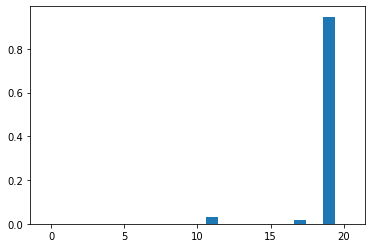

In [ ]:
sequence_idx = 0
aa_idx = 3
# test_seq = sample_output[0][sequence_idx][aa_idx]
test_seq = generated_sequence_tensor[sequence_idx][aa_idx]
# plt.bar(range(21), tf.math.round(test_seq.numpy()))
plt.bar(range(21), test_seq.numpy())
plt.show()

## Latent Code Perturbation (Analysis 3): 

>Among the 20 AI-designed AMP candidates, two sequences, YLRLIRYMAKMI-CONH2 (YI12, 12 amino acids) and FPLTWLKWWKWKK-CONH2 (FK13, 13 amino acids), were identified to be the best with the lowest MIC values (Table 1 and Supplementary Table 7) (das et al., 2021).\
They also claim low in vitro toxicity and in vivo against mice. 


Feed in these sequences, perturb their latent codes, and follow the analysis procedure as outlined in "MODEL ANALYSES" in Notability.

## Model Parameter Analysis (Analysis 4)

### Encoding LSTM weight matrices

In [ ]:
model_tuned.layers[4]

In [16]:
encoder_LSTM = model_tuned.layers[4]

In [27]:
encoder_LSTM.input

<KerasTensor: shape=(None, 50, 21) dtype=float32 (created by layer 'aa')>

In [19]:
weights = encoder_LSTM.get_weights()

In [20]:
for W in weights:
  print(W.shape)

(21, 200)
(50, 200)
(200,)


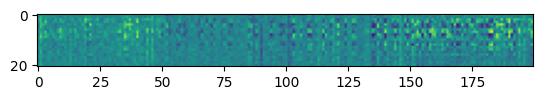

In [22]:
plt.imshow(weights[0])

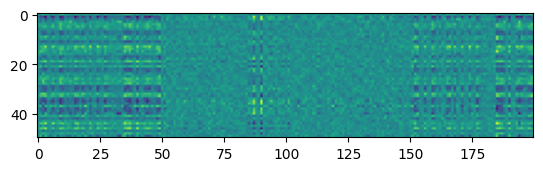

In [24]:
plt.imshow(weights[1])

In [ ]:
# import matplotlib.pyplot as plt
# # Extract the LSTM layer from the model
# # lstm_layer = best_model.get_layer('lstm_1')
# # encoder_LSTM = best_model.layers[3]



# # Get the weights of the LSTM layer
# weights = encoder_LSTM.get_weights()

# # Extract the weight matrices
# W_i = weights[0]
# W_f = weights[1]
# W_c = weights[2]
# W_o = weights[3]

# # Extract the bias vectors
# b_i = weights[4]
# b_f = weights[5]
# b_c = weights[6]
# b_o = weights[7]

# # Visualize the correlations between time steps
# fig, axs = plt.subplots(2, 2)
# axs[0, 0].imshow(W_i)
# axs[0, 0].set_title('W_i')
# axs[0, 1].imshow(W_f)
# axs[0, 1].set_title('W_f')
# axs[1, 0].imshow(W_c)
# axs[1, 0].set_title('W_c')
# axs[1, 1].imshow(W_o)
# axs[1, 1].set_title('W_o')
# plt.show()


IndexError: ignored